## 0) Importing Datasets and Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns 
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.metrics import accuracy_score

# 1) ANN model on the CIFAR10 dataset

In [3]:

# Load the CIFAR10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


170498071/170498071 [==============================] - 13s 0us/step


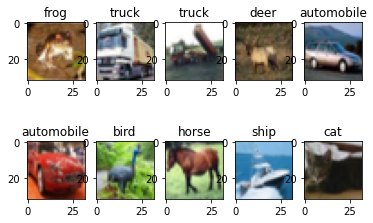

In [4]:
def plot_classes():    
    classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
    fig, ax = plt.subplots(nrows=2, ncols=5)
    index = 0
    for row in ax:
        for col in row:
            col.imshow(x_train[index])
            col.title.set_text(classes[y_train[index][0]])
            index += 1
    plt.show()

plot_classes()

In [5]:
# Preprocessing 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


In [6]:
# Convert class vectors to binary class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [22]:
# Model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [23]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [24]:
# Training the model
batch_size = 32
epochs = 50
callbacks = EarlyStopping(
    monitor="loss",
    patience=3,
    verbose=1,
    restore_best_weights=True
)
history = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose=1,callbacks = [callbacks])

Epoch 1/50
391/391 [==============================] - 4s 10ms/step - loss: 1.5583 - accuracy: 0.4303
Epoch 2/50
391/391 [==============================] - 4s 9ms/step - loss: 1.1046 - accuracy: 0.6069
Epoch 3/50
391/391 [==============================] - 4s 9ms/step - loss: 0.9254 - accuracy: 0.6744
Epoch 4/50
391/391 [==============================] - 4s 9ms/step - loss: 0.7886 - accuracy: 0.7246
Epoch 5/50
391/391 [==============================] - 4s 10ms/step - loss: 0.6677 - accuracy: 0.7661
Epoch 6/50
391/391 [==============================] - 4s 9ms/step - loss: 0.5607 - accuracy: 0.8031
Epoch 7/50
391/391 [==============================] - 4s 9ms/step - loss: 0.4629 - accuracy: 0.8373
Epoch 8/50
391/391 [==============================] - 4s 9ms/step - loss: 0.3901 - accuracy: 0.8644
Epoch 9/50
391/391 [==============================] - 4s 10ms/step - loss: 0.3214 - accuracy: 0.8896
Epoch 10/50
391/391 [==============================] - 4s 9ms/step - loss: 0.2756 - accuracy: 0.9

In [25]:
# Evaluating model on the test data
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.6784855127334595
Test accuracy: 0.7037000060081482


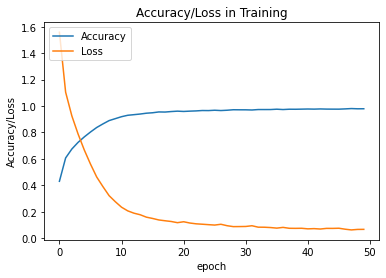

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.ylabel('Accuracy/Loss')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.title("Accuracy/Loss in Training")
plt.show()

# 2) Binary classification on churn modeling dataset

In [3]:
# Load the data
df = pd.read_csv("/content/drive/MyDrive/Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


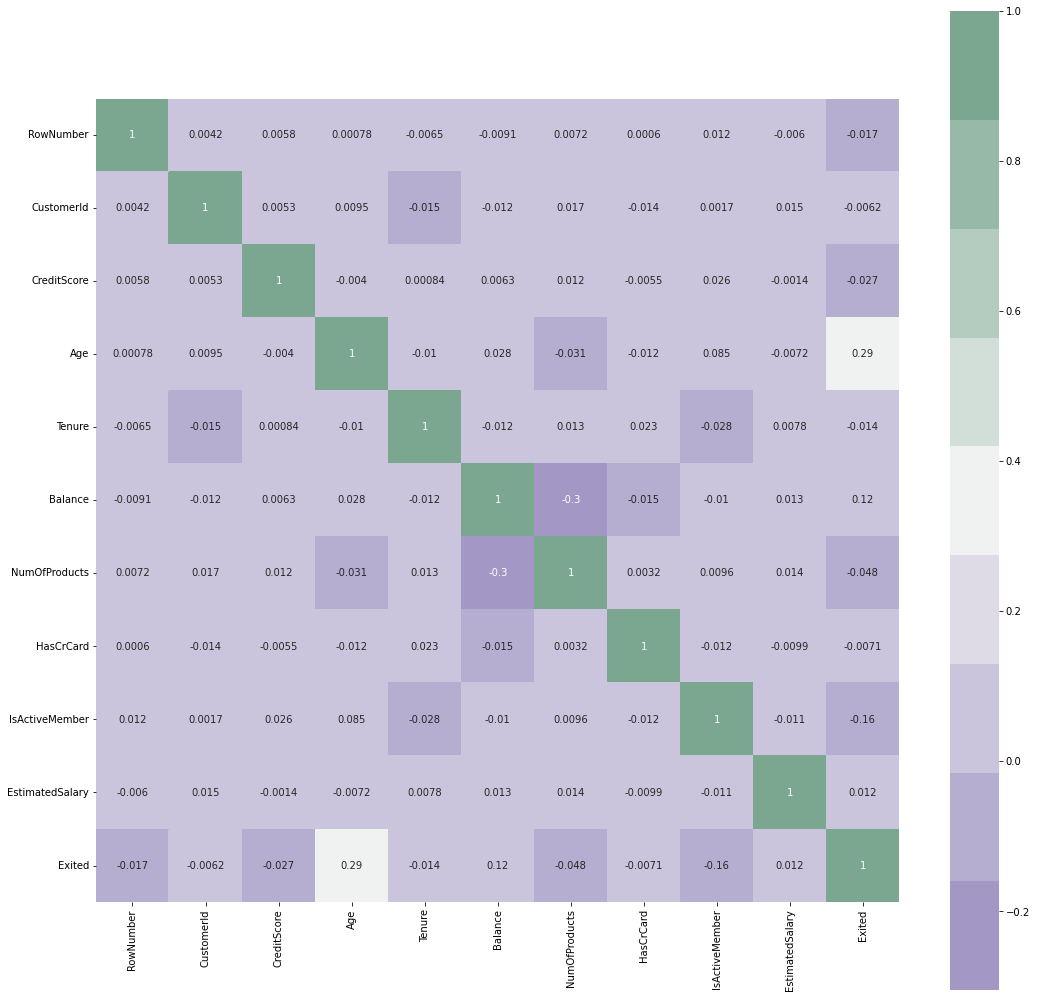

In [4]:
import seaborn as sns
cmap=sns.diverging_palette(275,150,  s=40, l=65, n=9)
corrmat = df.corr()
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap=cmap,annot=True, square=True);

In [5]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
df["Exited"].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

 **Class imbalance problem**

In [7]:
df.drop(["RowNumber","CustomerId","Surname"],axis="columns",inplace=True)

In [8]:
# Label Encoding
df = pd.get_dummies(df,columns=["Geography","Gender"])

In [9]:
# Split the data into features and target
X = df.drop(columns=["Exited"]).values
y = df["Exited"].values

In [10]:
# Balancing the class imbalance
from imblearn.over_sampling import SMOTE
cb=SMOTE()
X,y=cb.fit_resample(X,y)

print(Counter(y))

Counter({1: 7963, 0: 7963})


In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
from sklearn.preprocessing import MinMaxScaler
mms=MinMaxScaler()

X_train=mms.fit_transform(X_train)
X_test = mms.transform(X_test)


In [14]:
# Building the ANN model
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))


In [15]:
# Compile the model
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history=model.fit(X_train, y_train,epochs=100, batch_size=50)


Epoch 1/100
255/255 [==============================] - 3s 6ms/step - loss: 0.5786 - accuracy: 0.6990
Epoch 2/100
255/255 [==============================] - 1s 2ms/step - loss: 0.4616 - accuracy: 0.7880
Epoch 3/100
255/255 [==============================] - 1s 2ms/step - loss: 0.3908 - accuracy: 0.8251
Epoch 4/100
255/255 [==============================] - 1s 2ms/step - loss: 0.3491 - accuracy: 0.8428
Epoch 5/100
255/255 [==============================] - 1s 2ms/step - loss: 0.3260 - accuracy: 0.8556
Epoch 6/100
255/255 [==============================] - 1s 2ms/step - loss: 0.3154 - accuracy: 0.8617
Epoch 7/100
255/255 [==============================] - 1s 2ms/step - loss: 0.3115 - accuracy: 0.8617
Epoch 8/100
255/255 [==============================] - 1s 2ms/step - loss: 0.3076 - accuracy: 0.8630
Epoch 9/100
255/255 [==============================] - 1s 2ms/step - loss: 0.2951 - accuracy: 0.8714
Epoch 10/100
255/255 [==============================] - 1s 2ms/step - loss: 0.2914 - accura

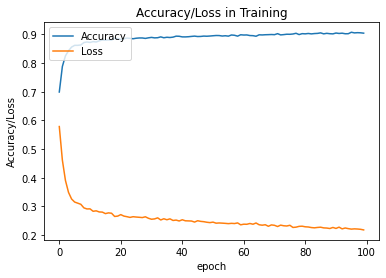

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.ylabel('Accuracy/Loss')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.title("Accuracy/Loss in Training")
plt.show()

In [16]:
# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


100/100 [==============================] - 0s 1ms/step


In [17]:
# Print the performance metrics
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1))


Accuracy: 0.89
Precision: 0.91
Recall: 0.87
F1-Score: 0.89


# 3) Multiple Linear Regression on the house price prediction dataset

In [30]:
Train = pd.read_csv("/content/drive/MyDrive/train.csv")

In [31]:
Train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [32]:
empty = Train.isnull().sum()
empty = empty[empty > 400]
empty.sort_values(inplace = True)
idx = empty.index
print(empty)

FireplaceQu     690
Fence          1179
Alley          1369
MiscFeature    1406
PoolQC         1453
dtype: int64


In [33]:
Train = Train.drop(columns = idx, axis = 1)

In [34]:
NoVal = Train.replace(0, np.nan)
NoVal = NoVal.isna().sum()
NoVal = NoVal[NoVal > 200]
NoVal.sort_values(inplace = True)
idx = NoVal.index
print(NoVal)

LotFrontage       259
BsmtFinSF1        467
OpenPorchSF       656
Fireplaces        690
WoodDeckSF        761
2ndFlrSF          829
BsmtFullBath      856
MasVnrArea        869
HalfBath          913
EnclosedPorch    1252
BsmtFinSF2       1293
ScreenPorch      1344
BsmtHalfBath     1378
MiscVal          1408
LowQualFinSF     1434
3SsnPorch        1436
PoolArea         1453
dtype: int64


In [35]:
Train = Train.drop(columns = idx, axis = 1)

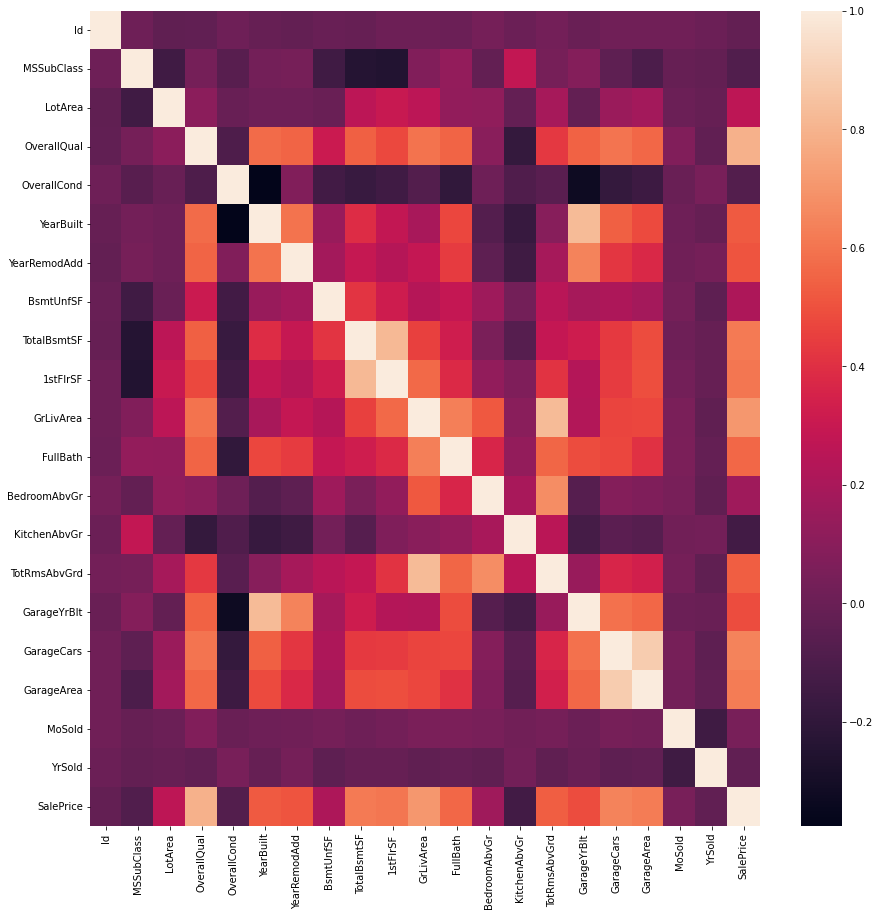

In [36]:
plt.figure(figsize=(15,15))
sns.heatmap(Train.corr())

In [50]:
cols = list(Train.corr() ["SalePrice"][(Train.corr()["SalePrice"]>0.05) |(Train.corr()["SalePrice"]<-0.05)].index)
cols

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'SalePrice']

In [51]:
col = Train[Train.columns.intersection(cols)]
X = col.drop("SalePrice",axis=1)
y = col["SalePrice"]
X = X.fillna(0)

In [52]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
scalery = StandardScaler()
y=y.values.reshape(-1,1)
Y = scalery.fit_transform(y)

X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [53]:
model=Sequential()
model.add(Dense(1024,activation='relu',input_dim=X_train.shape[1]))

model.add(Dense(512,activation='relu'))

model.add(Dense(64,activation='relu'))

model.add(Dense(16,activation='relu'))

model.add(Dense(1,activation='relu'))
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mean_squared_error'])
model.fit(X_train,y_train,batch_size=15,epochs=100)

Epoch 1/100
78/78 [==============================] - 1s 3ms/step - loss: 0.5680 - mean_squared_error: 0.5680
Epoch 2/100
78/78 [==============================] - 0s 3ms/step - loss: 0.4172 - mean_squared_error: 0.4172
Epoch 3/100
78/78 [==============================] - 0s 3ms/step - loss: 0.4314 - mean_squared_error: 0.4314
Epoch 4/100
78/78 [==============================] - 0s 3ms/step - loss: 0.3806 - mean_squared_error: 0.3806
Epoch 5/100
78/78 [==============================] - 0s 3ms/step - loss: 0.3872 - mean_squared_error: 0.3872
Epoch 6/100
78/78 [==============================] - 0s 3ms/step - loss: 0.3552 - mean_squared_error: 0.3552
Epoch 7/100
78/78 [==============================] - 0s 3ms/step - loss: 0.3670 - mean_squared_error: 0.3670
Epoch 8/100
78/78 [==============================] - 0s 3ms/step - loss: 0.3893 - mean_squared_error: 0.3893
Epoch 9/100
78/78 [==============================] - 0s 3ms/step - loss: 0.3614 - mean_squared_error: 0.3614
Epoch 10/100
78/78 

In [55]:
pred = model.predict(X_test)
mae = mean_absolute_error(y_test,pred)
mse = mean_squared_error(y_test,pred)
rmse = np.sqrt(mse)
print("mae=",mae)
print("mse=",mse)
print("rmse=",rmse)


10/10 [==============================] - 0s 2ms/step
mae= 0.5464025354958046
mse= 0.4714147417004836
rmse= 0.6865964911798512


## 4) Analysis of performance of heart rate classification using ANN and regression models.

### ANN Model

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

In [57]:
df1 = pd.read_csv("/content/drive/MyDrive/heart.csv") # Heart Attack Data 
df1.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [58]:
df1 = df1[(df1['thalach'] > 80)]  
df1 = df1[(df1['chol'] < 380)]
df1 = df1[(df1['oldpeak'] < 4.5)]
df1 = df1[(df1['trestbps'] < 170)]

In [59]:
x = df1.iloc[:,0:13]
y = df1.iloc[:,13:14]
x_train,x_val,y_train,y_val = train_test_split(x,y,shuffle = True,test_size=0.25)

# One Hot Encoding
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

In [60]:
model = Sequential()
model.add(Dense(128, input_dim=13, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history=model.fit(x_train, y_train, epochs=50, validation_data = (x_val,y_val), batch_size=32)

Epoch 1/50
23/23 [==============================] - 1s 11ms/step - loss: 0.6148 - accuracy: 0.6695 - val_loss: 0.4413 - val_accuracy: 0.8577
Epoch 2/50
23/23 [==============================] - 0s 4ms/step - loss: 0.4210 - accuracy: 0.8235 - val_loss: 0.3101 - val_accuracy: 0.8745
Epoch 3/50
23/23 [==============================] - 0s 4ms/step - loss: 0.3620 - accuracy: 0.8599 - val_loss: 0.2717 - val_accuracy: 0.9121
Epoch 4/50
23/23 [==============================] - 0s 4ms/step - loss: 0.3237 - accuracy: 0.8669 - val_loss: 0.2530 - val_accuracy: 0.9121
Epoch 5/50
23/23 [==============================] - 0s 5ms/step - loss: 0.2909 - accuracy: 0.8739 - val_loss: 0.2358 - val_accuracy: 0.9121
Epoch 6/50
23/23 [==============================] - 0s 4ms/step - loss: 0.2538 - accuracy: 0.8936 - val_loss: 0.2105 - val_accuracy: 0.9205
Epoch 7/50
23/23 [==============================] - 0s 6ms/step - loss: 0.2335 - accuracy: 0.9090 - val_loss: 0.2067 - val_accuracy: 0.9205
Epoch 8/50
23/23 [=

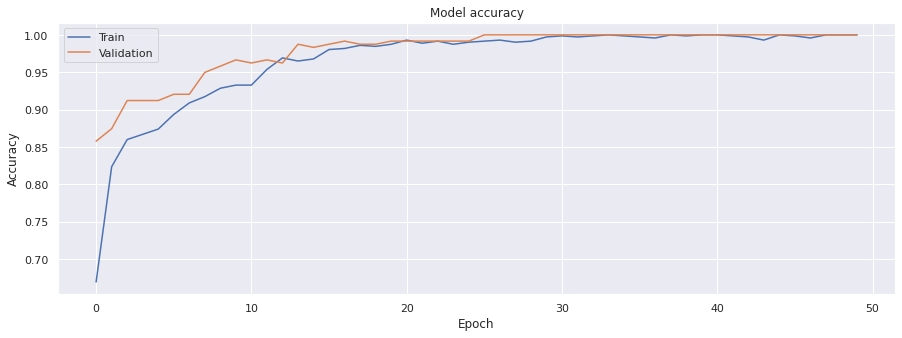

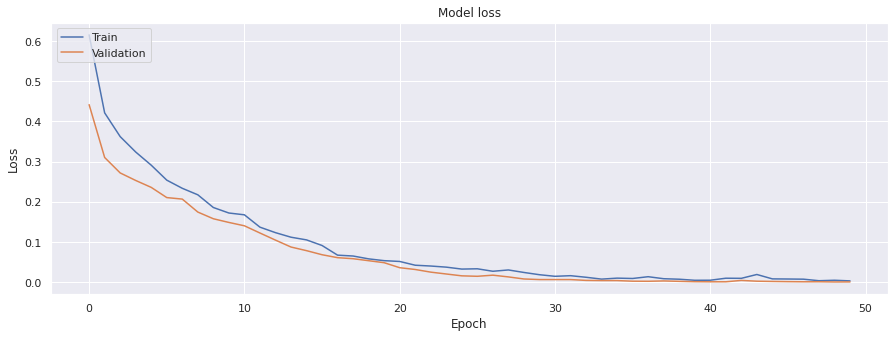

In [61]:
sns.set(rc={'figure.figsize':(15,5)})
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

8/8 [==============================] - 0s 2ms/step


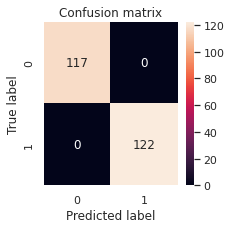

In [62]:
sns.set(rc={'figure.figsize':(3,3)})

# Generate predictions for the test data
y_pred = model.predict(x_val)

# Convert predictions to class labels
y_pred_class = np.argmax(y_pred, axis=1)
y_test_class = np.argmax(y_val, axis=1)

# Compute confusion matrix
confusion_mtx = confusion_matrix(y_test_class, y_pred_class)

# Plot confusion matrix
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### Classical Models

In [ ]:
x = df1.iloc[:,0:13]
y = df1.iloc[:,13:14]
x_train,x_val,y_train,y_val = train_test_split(x,y,shuffle = True,test_size=0.25)


#### Sklearn Logistic Regression 

In [63]:
from sklearn.linear_model import LogisticRegression

In [76]:

# Fit the logistic regression model to the training data
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(x_train, y_train)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=1000)

In [77]:

predictions= log_reg.predict(x_val)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_val,predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 87.03%


#### Random Forest Classifier

In [78]:
from sklearn.ensemble import RandomForestClassifier

In [80]:
rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(x_train, y_train)

# Predict labels for the test data
predictions = rfc.predict(x_val)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_val,predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 98.74%


<ipython-input-80-8f2bb140f5cd>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(x_train, y_train)


### Final Comparision

|Model|Accuracy|
|--|--|
|ANN| 100|
|Logistic Regression|87.03|
|Random Forest Classifier|98.74|